<a href="https://colab.research.google.com/github/22222bh/SketchTogether/blob/user%2FByeonghyeon/knn_model_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=411593f752748b42de5396685071f64190d008df6ada4e20786f3edeae5f76c0
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [1]:
from torch import nn

In [9]:
class knnModel(nn.Module):
    def __init__(self):
        super(knnModel, self).__init__()
        from efficientnet_pytorch import EfficientNet
        from sklearn.cluster import KMeans
        from sklearn.decomposition import PCA
        # from keras.applications.vgg16 import VGG16 
        # from keras.models import Model
        # from keras.applications.vgg16 import preprocess_input 
        import os
        import logging
        import torch
        from torch import nn
        import pickle
        from tqdm import tqdm
        from torchvision import transforms
        import numpy as np
        import pandas as pd
        

        print('init')
        self.feat_path = "/content/drive/MyDrive/skku_Clustering/features_hw_filtered_10.npy"
        self.filename_path = "/content/drive/MyDrive/skku_Clustering/filenames_hw_filtered_10.npy"
        self.feat = np.load(self.feat_path)
        self.filenames = np.load(self.filename_path)
        #transform
        self.tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
        self.pooling = nn.AdaptiveAvgPool2d(1)

        # self.effi_model = EfficientNet.from_pretrained('efficientnet-b0')
        self.effi_model = torch.load('/content/drive/MyDrive/Sketch_RNN/skku_Clustering/torch_model/efficient.pt')
  
    def forward(self, input):
      print('forward')
      from PIL import Image
      import numpy as np
      from sklearn.manifold import TSNE
      from sklearn.neighbors import NearestNeighbors
      import matplotlib.pyplot as plt
      def feature_extraction(image, model):
          img = self.tfms(Image.open(image).convert("RGB")).unsqueeze(0)
          feature = model.extract_features(img)
          features = self.pooling(feature)
          return features
      
      new_data = {}
      
      new_feat = feature_extraction(input, self.effi_model)
      new_feat = new_feat.detach().numpy().reshape(-1)
      new_data[input] = (new_feat)
      
      self.feat = np.append(self.feat, np.array(list(new_data.values())), axis = 0)
      self.filenames = np.append(self.filenames, np.array(list(new_data.keys())), axis = 0)
      tsne = TSNE(n_components=2, init='pca', random_state=0)
      x = tsne.fit_transform(self.feat)

      knn = NearestNeighbors(n_neighbors=6, algorithm='auto').fit(x)
      distances, indices = knn.kneighbors([list(x[-1])])

      image = []
      name = []
      data_path = '/content/drive/MyDrive/Sketch_RNN/Dataset/Filtered_img/'
      for i, idx in enumerate(indices[0]):
        if self.filenames[idx].startswith('/'):
          image.append(np.array(Image.open(self.filenames[idx])))
          name.append(self.filenames[idx].split('/')[-1].split('.')[0])
        else:
          image.append(np.array(Image.open(data_path + self.filenames[idx].split('_')[0] + '/' + self.filenames[idx] + '.jpg'))) # 코랩용
          # image.append(np.array(Image.open(data_path + '/' + self.filenames[idx] + '.jpg'))) # 안스용
          name.append(self.filenames[idx].split('/')[-1].split('.')[0])

      for i, img in enumerate(image):
        plt.subplot(1,6,i+1)
        plt.title(name[i])
        plt.imshow(img, 'gray')

      plt.tight_layout()
      plt.show()

In [ ]:
model('/content/drive/MyDrive/skku_Clustering/test_set/cloud/test_cloud_1.jpg')

In [10]:
model = knnModel()
model.eval()
model('/content/drive/MyDrive/skku_Clustering/test_set/cloud/test_cloud_1.jpg')
torch.save(model.state_dict(), model_path + 'plz.pt')


ModuleNotFoundError: ignored

In [7]:
from efficientnet_pytorch import EfficientNet
import torch
effi_model = EfficientNet.from_pretrained('efficientnet-b0')
model_path = '/content/drive/MyDrive/skku_Clustering/torch_model/'
torch.save(effi_model.state_dict(), model_path + 'efficient.pt')


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [ ]:
torch.save(model, model_path + 'plz.pt')

forward


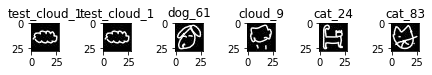

In [7]:
import torch
a = torch.load('/content/drive/MyDrive/skku_Clustering/torch_model/plz.pt')
a.eval()
a('/content/drive/MyDrive/skku_Clustering/test_set/cloud/test_cloud_1.jpg')

In [8]:
# import torch
model = torch.load_state_dict('/content/drive/MyDrive/skku_Clustering/torch_model/efficient.pt')
res = a('/content/drive/MyDrive/skku_Clustering/test_set/cloud/test_cloud_1.jpg')

AttributeError: ignored